# Self Organized Maps (SOMs)

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps
# from simpsom.plots import scatter_on_map

# Astropy
from astropy.table import Table

# CuPY
import cupy as cp

## PCA Whitening and ZPCA Whitening

[Link to Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)

[Link to Visualization](https://setosa.io/ev/principal-component-analysis/)

In [47]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

In [49]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))
    X_centered = (eigvecs @ D_sqrt @ eigvecs.T @ whitened_data.T).T
    x_dewhitened = X_centered + data_mean

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean

    return x_orig


## Catalogs Matched Without Magnitudes in NWAY

Import the catalog

In [4]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.83
matched_no_mags_path = '/data/mfonseca/cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag.fits'
matched_no_mags = Table.read(matched_no_mags_path)
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [5]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 11263


Select the objects that have matches in all the three surveys

In [6]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]
print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in all three surveys 4207


Select the columns to run the SOMs

1. Magnitudes: (DES Y6 GOLD), (VIKING DR5), (CATWISE)
2. Features: 
3. Redshifts: BNF_z (DES Y6 GOLD)

In [7]:
# Filter the multiwavelenght catalog to keep only the columns needed
emu_columns = ['EMU_island_id']

# desdr2_mag = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered']
# desdr2_colors = ['DES_g_r_dered', 'DES_r_i_dered', 'DES_i_z_dered']

# Technically only need one magnitude to recover the rest from the colors
desy6gold_mag = ['DESY6_mag_auto_g_extcorr', 'DESY6_mag_auto_r_extcorr', 'DESY6_mag_auto_i_extcorr', 'DESY6_mag_auto_z_extcorr', 'DESY6_mag_auto_y_extcorr']
desy6gold_colors = ['DESY6_g_r_extcorr', 'DESY6_r_i_extcorr', 'DESY6_i_z_extcorr', 'DESY6_z_y_extcorr']
desy6gold_features = ['DESY6_dnf_z', 'DESY6_spread_model_g', 'DESY6_spread_model_r', 'DESY6_spread_model_i', 'DESY6_spread_model_z']

viking_mag = ['VKG_zAperMag3_ab_extcorr', 'VKG_jAperMag3_ab_extcorr', 'VKG_yAperMag3_ab_extcorr', 'VKG_ksAperMag3_ab_extcorr', 'VKG_hAperMag3_ab_extcorr']
viking_colors = ['VKG_z_y_am3_extcorr', 'VKG_y_j_am3_extcorr', 'VKG_j_h_am3_extcorr', 'VKG_h_ks_am3_extcorr']
viking_features = ['VKG_mergedClassStat']

catwise_mag = ['CAT_w1mpro_ab', 'CAT_w2mpro_ab']
catwise_colors = ['CAT_w1_w2_ab']

columns = ([desy6gold_mag[0]] + [viking_mag[0]] + [catwise_mag[0]]) + (desy6gold_colors + viking_colors + catwise_colors) + (desy6gold_features + viking_features)

catalog_som = catalog_matches_noMags_full[columns]

In [8]:
catalog_som_clean = catalog_som[~catalog_som.isin([-999999488.0]).any(axis=1)]
catalog_som_clean.describe()
len(catalog_som_clean)

3838

### Define the topology of the SOM

In [ ]:
data_fraction2use = 1
data = catalog_som_clean.sample(frac=data_fraction2use)

data.to_numpy()

data_white = pca_whitening(data)
print(data)

data_dewhite = inverse_pca_whitening(data, data_white)
print(data_dewhite)

         0   1   2   3   4   5   6   7   8   9  ...  DESY6_spread_model_i  \
1045   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
49454  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
80289  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
68033  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
64735  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...                   ...   
34574  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
8546   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
43789  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
72225  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   
100394 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...                   NaN   

        DESY6_spread_model_r  DESY6_spread_model_z  DESY6_z_y_extcorr  \
10

In [10]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(data_white)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(data_white, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

Dimension of the SOM:  309
Square SOM map size  18.0
Ratio of the two largest eigenvalues:  1
SOM map size using eigenvalues:  17 x 16
Resized SOM map size using eigenvalues:  34 x 33


### Run the SOM

In [11]:
# Define the SOM
som = sps.SOMNet(
    18,
    18,
    data_white,
    load_file = None,
    metric= 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = True,
    random_seed = 69,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True
)

som.train(
    train_algo = 'batch', 
    epochs = 100,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-04-29 21:42:35.087 | INFO     | simpsom.network:__init__:109 - Periodic Boundary Conditions active.
2025-04-29 21:42:35.088 | INFO     | simpsom.network:__init__:118 - Hexagonal topology.
2025-04-29 21:42:35.089 | INFO     | simpsom.network:_set_weights:194 - The weights will be initialized randomly.
2025-04-29 21:42:35.189 | INFO     | simpsom.network:train:419 - The map will be trained with the batch algorithm.
2025-04-29 21:42:35.282 | DEBUG    | simpsom.network:train:542 - Training SOM... 0.00%
2025-04-29 21:42:36.311 | DEBUG    | simpsom.network:train:542 - Training SOM... 10.00%
2025-04-29 21:42:37.160 | DEBUG    | simpsom.network:train:542 - Training SOM... 20.00%
2025-04-29 21:42:38.011 | DEBUG    | simpsom.network:train:542 - Training SOM... 30.00%
2025-04-29 21:42:38.864 | DEBUG    | simpsom.network:train:542 - Training SOM... 40.00%
2025-04-29 21:42:39.714 | DEBUG    | simpsom.network:train:542 - Training SOM... 50.00%
2025-04-29 21:42:40.565 | DEBUG    | simpsom.networ

2025-04-29 21:42:44.002 | INFO     | simpsom.network:get_nodes_difference:643 - Weights difference among neighboring nodes calculated.


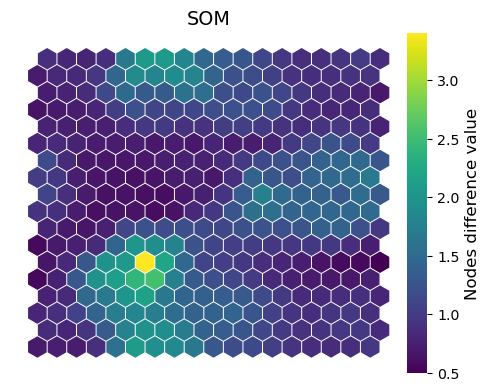

In [12]:
som.plot_map_by_difference(show=True, print_out=False)

### Plot value of features

This code plots the values of each feature in each node. Remember that this value is after PCA/ZCA, so it needs to be converted back.

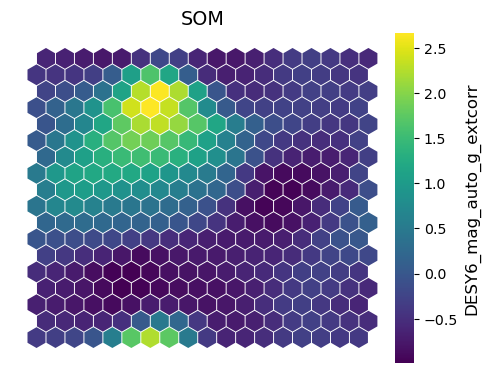

2025-04-29 21:42:44.662 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_0.png


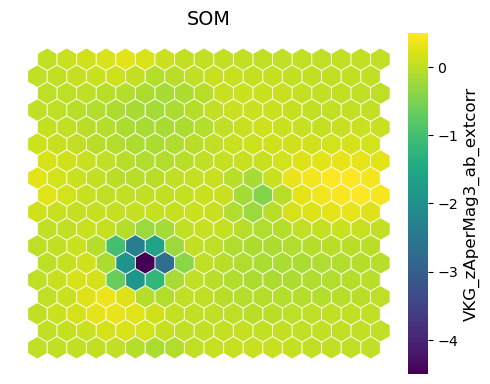

2025-04-29 21:42:45.016 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_1.png


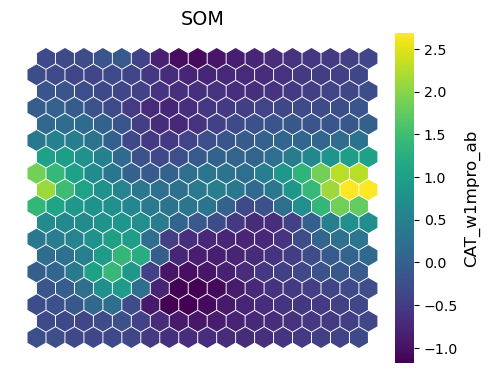

2025-04-29 21:42:45.377 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_2.png


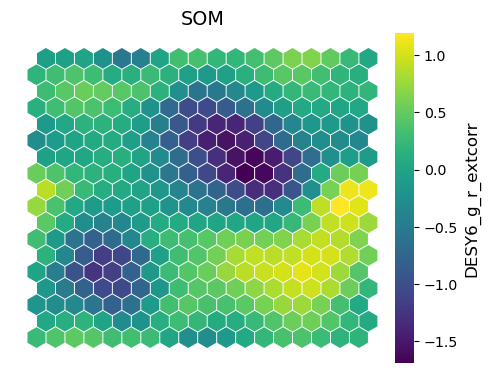

2025-04-29 21:42:45.731 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_3.png


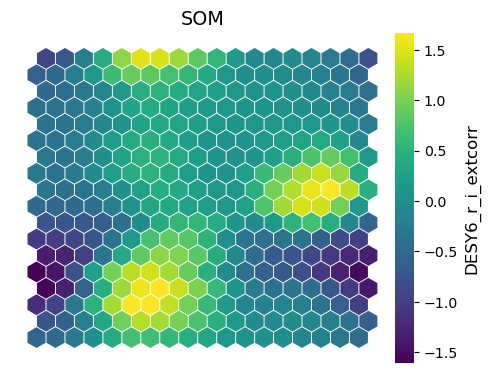

2025-04-29 21:42:46.086 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_4.png


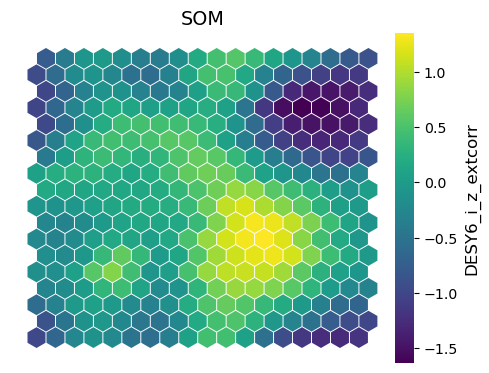

2025-04-29 21:42:46.436 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_5.png


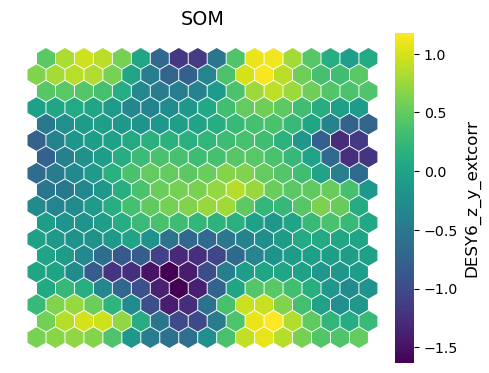

2025-04-29 21:42:46.873 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_6.png


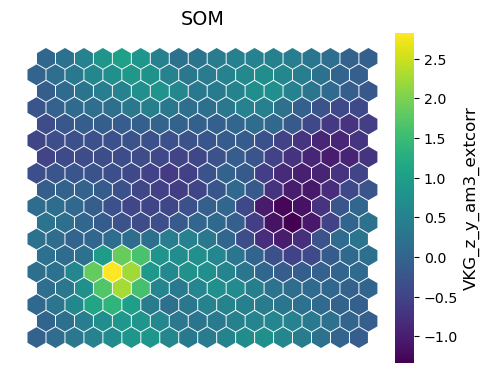

2025-04-29 21:42:47.235 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_7.png


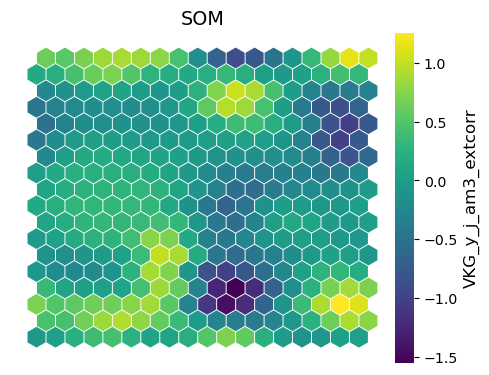

2025-04-29 21:42:47.586 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_8.png


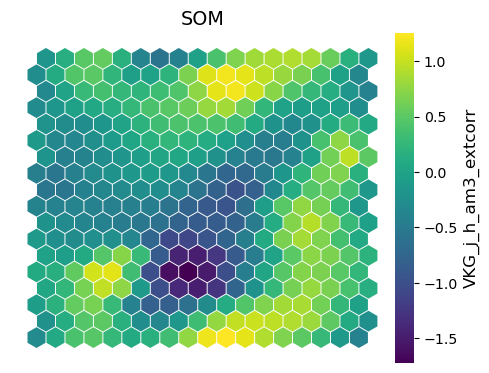

2025-04-29 21:42:47.937 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_9.png


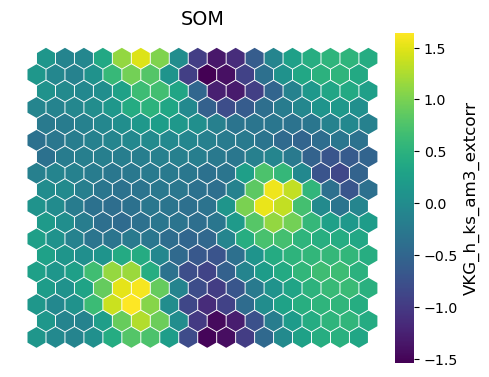

2025-04-29 21:42:48.299 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_10.png


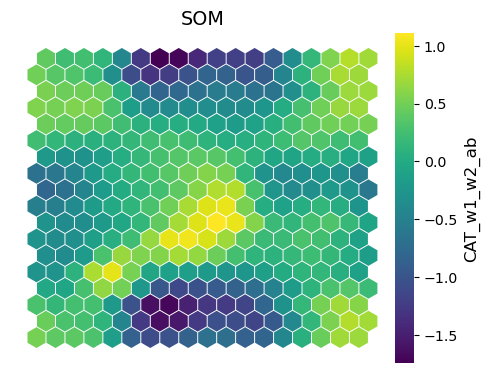

2025-04-29 21:42:48.650 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_11.png


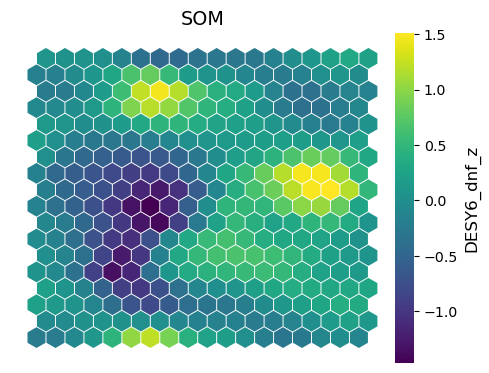

2025-04-29 21:42:49.004 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_12.png


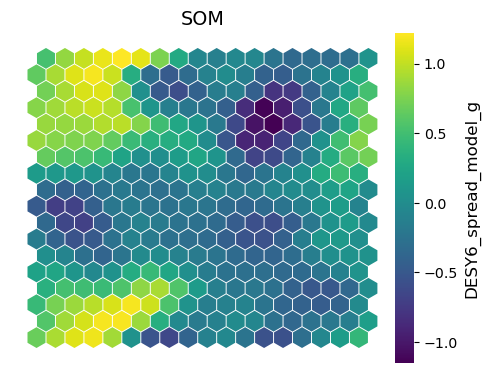

2025-04-29 21:42:49.351 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_13.png


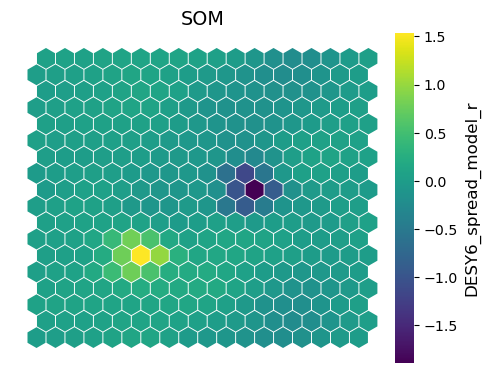

2025-04-29 21:42:49.808 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_14.png


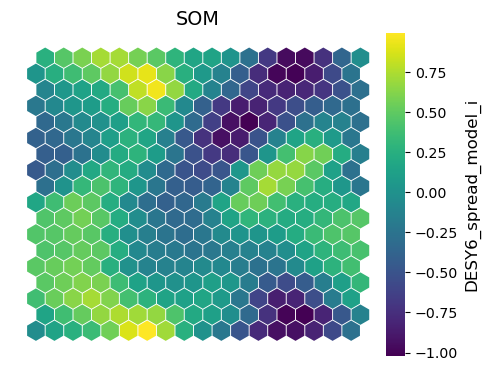

2025-04-29 21:42:50.175 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_15.png


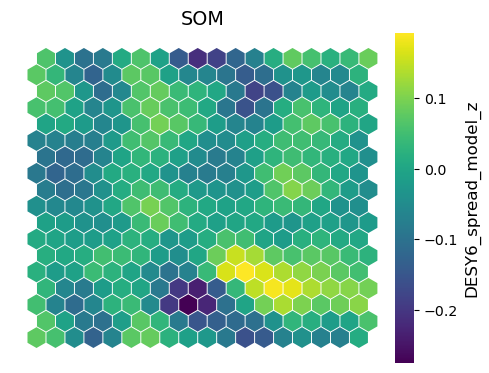

2025-04-29 21:42:50.518 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_16.png


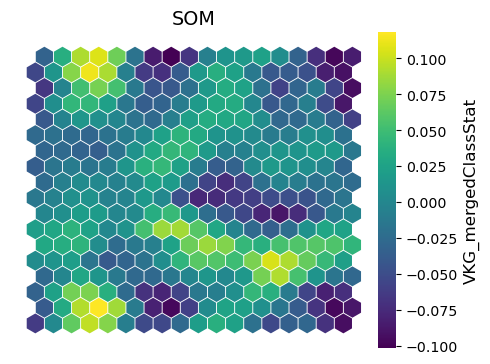

2025-04-29 21:42:50.887 | INFO     | simpsom.network:plot_map_by_feature:777 - Feature map will be saved to:
././som_feature_17.png


In [13]:
for i in range(len(columns)):
    som.plot_map_by_feature(
        feature_ix= i,
        show=True,
        print_out=True,
        cbar_label=catalog_som_clean.columns[i],
    )

2025-04-29 21:42:50.970 | INFO     | simpsom.network:project_onto_map:668 - Projected coordinates will be saved to:
././som_projected.npy


[ 1.   7.5  9.5 ... 12.  16.   4.5]


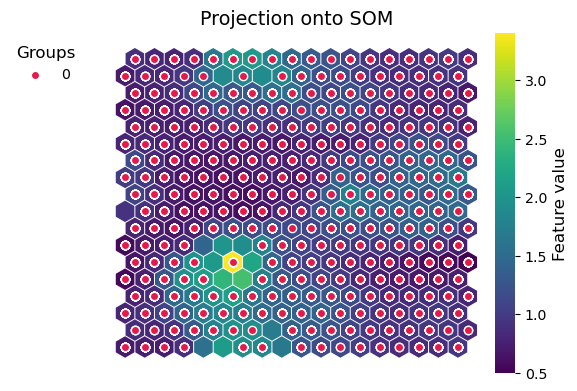

In [14]:
projected_data = som.project_onto_map(data_white)
som.plot_projected_points(projected_data, color_val=[n.difference for n in som.nodes_list],
        project=False, jitter=False,
        show=True, print_out=False)

In [15]:
all_positions = [[node.pos[0], node.pos[1]] for node in som.nodes_list]
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(columns))] for node in som.nodes_list]

# convert back to the original feature space
weights_dewhitened = inverse_pca_whitening(data_white, all_weights)

feature_idx = 12

weights_dewhitened_feature = [weights_dewhitened[row][feature_idx] for row in range(len(weights_dewhitened))]

print(weights_dewhitened_feature)

ValueError: shapes (18,18) and (3838,18) not aligned: 18 (dim 1) != 3838 (dim 0)

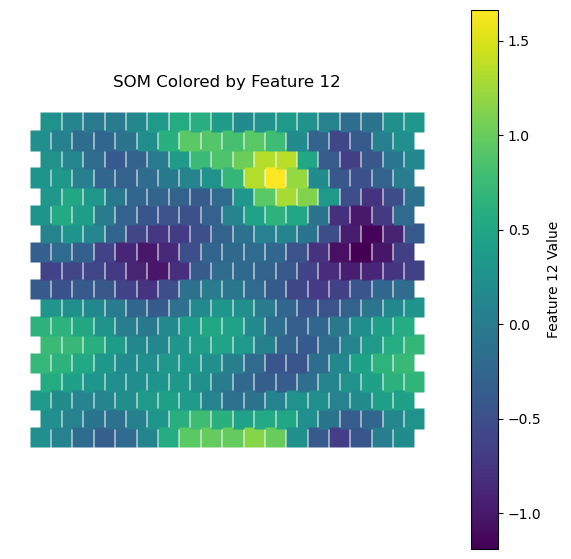

In [ ]:
# Create a matplotlib figure
fig = plt.figure(figsize=(7, 7))

# Draw the SOM map using polygon tiling and color by the selected feature
ax = sps.polygons.Polygon.draw_map(fig, centers=all_positions, feature=weights_dewhitened_feature, cmap=plt.cm.viridis)

# Add a colorbar and labels
plt.colorbar(ax.collections[0], ax=ax, label=f'Feature {feature_idx} Value')
plt.title(f'SOM Colored by Feature {feature_idx}')
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.grid(True)
plt.show()

### Obtain the data values from each node

[[array(0., dtype=float32), array(0., dtype=float32)], [array(0.5, dtype=float32), array(0.8660254, dtype=float32)], [array(0., dtype=float32), array(1.7320508, dtype=float32)], [array(0.5, dtype=float32), array(2.598076, dtype=float32)], [array(0., dtype=float32), array(3.4641016, dtype=float32)], [array(0.5, dtype=float32), array(4.3301272, dtype=float32)], [array(0., dtype=float32), array(5.196152, dtype=float32)], [array(0.5, dtype=float32), array(6.0621777, dtype=float32)], [array(0., dtype=float32), array(6.928203, dtype=float32)], [array(0.5, dtype=float32), array(7.7942286, dtype=float32)], [array(0., dtype=float32), array(8.6602545, dtype=float32)], [array(0.5, dtype=float32), array(9.526279, dtype=float32)], [array(0., dtype=float32), array(10.392304, dtype=float32)], [array(0.5, dtype=float32), array(11.25833, dtype=float32)], [array(0., dtype=float32), array(12.124355, dtype=float32)], [array(0.5, dtype=float32), array(12.990381, dtype=float32)], [array(0., dtype=float32), 

## Catalogs Matched With Magnitudes in NWAY

Import the catalog

In [ ]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.05
matched_mags_path = '/data/mfonseca/cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_Mags/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_Mags.fits'
matched_mags = Table.read(matched_mags_path)
matched_mags = matched_mags.to_pandas()

In [ ]:
matched_mags['VKG_sourceID'].describe()

count    1.043490e+05
mean     2.220811e+11
std      2.902080e+11
min     -9.900000e+01
25%     -9.900000e+01
50%     -9.900000e+01
75%      6.013071e+11
max      6.013296e+11
Name: VKG_sourceID, dtype: float64

Filter using NWAY recomendations

In [ ]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_mags['match_flag'] == 1) & (matched_mags['p_i'] >= 0.1) & (matched_mags['p_any'] >=0.05)
catalog_matches_Mags = matched_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_Mags)}')

Number of objects in the catalog 7747


In [ ]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_Mags['DESY6_coadd_object_id'] != -99) & (catalog_matches_Mags['VKG_sourceID'] != -99) & (catalog_matches_Mags['CAT_source_id'] != b'-99')
catalog_matches_Mags_full = catalog_matches_Mags[full_match_mask]
print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_Mags_full)}')

Number of objects in the catalog that have matches in all three surveys 6211


In [ ]:
# Filter the multiwavelenght catalog to keep only the columns needed
emu_columns = ['EMU_island_id']

# desdr2_mag = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered']
# desdr2_colors = ['DES_g_r_dered', 'DES_r_i_dered', 'DES_i_z_dered']

desy6gold_mag = ['DESY6_mag_auto_g_extcorr', 'DESY6_mag_auto_r_extcorr', 'DESY6_mag_auto_i_extcorr', 'DESY6_mag_auto_z_extcorr', 'DESY6_mag_auto_y_extcorr']
desy6gold_colors = ['DESY6_g_r_extcorr', 'DESY6_r_i_extcorr', 'DESY6_i_z_extcorr', 'DESY6_z_y_extcorr']

viking_mag = ['VKG_zAperMag3_ab_extcorr', 'VKG_jAperMag3_ab_extcorr', 'VKG_yAperMag3_ab_extcorr', 'VKG_ksAperMag3_ab_extcorr', 'VKG_hAperMag3_ab_extcorr']
viking_colors = ['VKG_z_y_am3_extcorr', 'VKG_y_j_am3_extcorr', 'VKG_j_h_am3_extcorr', 'VKG_h_ks_am3_extcorr']

catwise_mag = ['CAT_W1mpro_ab', 'CAT_W2mpro_ab']
catwise_colors = ['CAT_w1_w2_ab']

colors_columns = desy6gold_colors + viking_colors +catwise_colors

catalog_matched = catalog_matched[colors_columns]

# Should be the same lenght as the filtered catalog
print(len(catalog_matched))

NameError: name 'catalog_matched' is not defined

In [ ]:
# Histograms of each columns

# for col in catalog_filtered_magnitude.columns:
#     plt.figure(figsize=(10, 5))
#     plt.hist(catalog_filtered_magnitude[col], bins=100, color='blue', alpha=0.7)
#     plt.title(f'Histogram of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.grid()
#     plt.show()

### Define the Topology

Define the topology of the SOM, follow indications from "Self-Organizing Maps and Their Applications to Data Analysis" R. Ponmalai, C. Kamath

In [ ]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(catalog_matched)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_std = catalog_matched.cov()
eigen_values = np.linalg.eigvals(cov_std.values)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes if 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

In [ ]:
# Definine the subset of the catalog to use
data_fraction2use = 1
data = catalog_matched.sample(frac=data_fraction2use)

# Normalize the data
data.to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values 

## Quantization Error (QE) and Topographic Error (TE)

In [ ]:
# THIS FUNCTION WORKS

# Quantization Error (QE)
# Average distance of a data point to the nearest lattice node
# Measures how well the mapping fits the distribution of the data

def som_quantization_error(data, trained_som):
    '''
    Calculates the quantization error of a trained SOM.ipynb

    Args:
        data: NumPy array of input data.
        trainded_som: trained SimpSOM SOMNet object

    Returns:
        quantization error (float)
    '''
    # Convert to clean NumPy array with uniform dtype first
    data_np = np.asarray(data, dtype=np.float64)

    # Convert NumPy array to CuPy array for GPU processing
    data_cp = cp.array(data_np)

    # Find all BMU indices
    bmu_indices = trained_som.find_bmu_ix(data_cp)

    # Get the weights of the BMUs
    bmu_weights = cp.array([trained_som.nodes_list[int(bmu_idx)].weights for bmu_idx in bmu_indices])

    # Vectorized distance calculation
    distances = cp.linalg.norm(bmu_weights - data_cp, axis=1)
    total_distance = cp.sum(distances)

    quantization_error = float(total_distance / len(data))
    return quantization_error


In [ ]:
# THIS FUNCTION WORKS

# Topographic Error (TE)
# Proportion of data points whose BMU and second BMU are NOT neighbors
# Measures how well the shape of the data is preserved in the output space

def som_topographic_error(data, trained_som):
    """
    Computes topographic error ET for a SOM with hex topology using GPU (CuPy).
    
    Args:
        data:    The input data used to train the SOM (NumPy array).
        trained_som: A trained SOMNet object from the simpsom library.

    Returns:
        Topographic error (float between 0 and 1).
        Proportion of data points whose BMU and second BMU are NOT neighbors
    """
    # Convert to clean NumPy array with uniform dtype first
    data_np = np.asarray(data, dtype=np.float64)

    # Convert data to CuPy arrays
    data_cp = cp.array(data)

    # Get all the nodes' weights from the trained SOM (GPU-enabled)
    weights_cp = cp.array([node.weights for node in trained_som.nodes_list])

    # Initialize total error
    total_error = 0

    # Find all BMU indices
    bmu_indices = trained_som.find_bmu_ix(data_cp)

    # Find all the second BMU indices
    som_dist = sps.distances.Distance(xp=np) # Initialize the distance object, as required by the documentation
    distances = som_dist.pairdist(data_cp, weights_cp, metric='euclidean')

    sorted_indices = cp.argsort(distances, axis=1)
    sbmu_indices = sorted_indices[:, 1]


    # Get the positions of the BMU and second BMU in the grid
    bmu_positions = cp.array([trained_som.nodes_list[int(bmu_idx)].pos for bmu_idx in bmu_indices])
    sbmu_positions = cp.array([trained_som.nodes_list[int(sbmu_idx)].pos for sbmu_idx in sbmu_indices])


    bmu_row, bmu_col = bmu_positions[:, 0], bmu_positions[:, 1]
    sbmu_row, sbmu_col = sbmu_positions[:, 0], sbmu_positions[:, 1]


    # Check if BMU and sBMU are neighbors
    row_neighbors = cp.abs(bmu_row - sbmu_row)
    col_neighbors = cp.abs(bmu_col - sbmu_col)

    not_neighbors = (row_neighbors > 1) | (col_neighbors > 1)

    number_not_neighbors = cp.sum(not_neighbors)

    # Compute the topographic error
    topographic_error = number_not_neighbors / data_cp.shape[0]

    return float(topographic_error)

# Running the SOM

In [ ]:
# Does not work correcly because the learning rate is not updated in each training epoch

def track_som_errors(data, epochs, net_height=20, net_width=20):
    som_net = sps.SOMNet(
        net_height=net_height,
        net_width=net_width,
        data=data,
        topology='hexagonal',
        init='PCA',
        metric='euclidean',
        neighborhood_fun='gaussian',
        PBC=True,
        GPU=True,
        random_seed=42,
        output_path="./"
    )

    quantization_errors = []
    topographic_errors = []

    for epoch in range(epochs):

        som_net.train(
            train_algo='batch',
            epochs=1,
            start_learning_rate = 0.1,
            early_stop=None,
            batch_size=-1
        )

        quant_error = som_quantization_error(data, som_net)
        topo_error = som_topographic_error(data, som_net)

        quantization_errors.append(quant_error)
        topographic_errors.append(topo_error)

        print(f"Epoch {epoch+1}/{epochs} | QE: {quant_error:.4f} | TE: {topo_error:.4f}")

    return quantization_errors, topographic_errors, som_net

In [ ]:
# Define the SOM
som = sps.SOMNet(
    som_y_resized,
    som_x_resized,
    data,
    load_file = None,
    metric= 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = True,
    random_seed = 69,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True
)

som.train(
    train_algo = 'batch', 
    epochs = 200,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 5 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

In [ ]:
som.save_map('/data/mfonseca/soms/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_Mags.npy')

## U-Matrix

In [ ]:
som.plot_map_by_difference(show=True, print_out=True)

## Plot Original Data points

## Plot Quantization Error and Topographic Error

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(net.quantization_error, label='Quantization Error', color='blue')
plt.plot(net.topographic_error, label='Topographic Error', color='orange')
plt.title('SOM Training Errors')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

## Component Planes

In [ ]:
for i in range(len(catalog_matched.columns)):
    som.plot_map_by_feature(
        feature_ix= i,
        show=True,
        print_out=True,
        cbar_label=catalog_matched.columns[i],
    )

# MiniSom

### Example

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5], 
                   sep='\t+', engine='python')
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values


# Initialization and training
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 500, verbose=True)

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=4, linewidths=10, color='k', label='centroid')
plt.legend(loc='best')

### With our galaxy values

In [ ]:
galaxy_names = catalog_df['EMU_island_name'].str.decode('utf-8').str.strip()

# Normalize the data
data = (catalog_df_filtered_matches_magnitude - np.mean(catalog_df_filtered_matches_magnitude, axis=0)) / np.std(catalog_df_filtered_matches_magnitude, axis=0)
data = data.values

In [ ]:
som_shape = (10, 10)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.1,
              neighborhood_function='gaussian', random_seed=0)

som.train_batch(data, 100000, verbose=True)

In [ ]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plt.xlim(-.5,1)
# plt.ylim(-1,1)
